In [3]:
from numcosmo_py import Ncm, Nc, GObject

import numpy as np
import math
import sys
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.special import erf 
import matplotlib.pyplot as plt

from scipy.optimize import minimize
import pandas as pd

from richness_mass_calib import create_richness_mass_calib

# #Settings
Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

In [4]:
# Data
DC2_halos_m200c = fits.open(
    "/global/cfs/projectdirs/lsst/groups/CL/cosmoDC2_v1.1.4/extragal/full/halos/halos_m200c_13.0.fits")

dt_halos = Table(DC2_halos_m200c[1].data)

rmdata = create_richness_mass_calib(dt_halos)
ascaso = Nc.ClusterMassAscaso()
lnrich_ext = Nc.ClusterMassLnrichExt()

In [5]:
lnM_a = np.log(dt_halos["mass_fof"])  # ln(mass)
z_a = dt_halos["redshift_true"]  # redshift
lnR_a = np.log(dt_halos["richness"])  # ln(richness)

In [6]:
kernel = Ncm.StatsDistKernelST.new(3, 1)
dist = Ncm.StatsDistVKDE.new(kernel, Ncm.StatsDistCV.NONE)

In [7]:
for lnM, z, lnR in zip(lnM_a, z_a, lnR_a):
    v = Ncm.Vector.new_array([lnM, z, lnR])
    dist.add_obs(v)
    if dist.props.N > 20000:
        break

In [8]:
dist.prepare()


In [9]:
min_lnR = min(lnR_a)
max_lnR = max(lnR_a)

lnR_range = np.linspace(min_lnR, max_lnR, 1000)

In [10]:
prob_lnR =  [dist.eval(Ncm.Vector.new_array([31.0, 1.2, lnR])) for lnR in lnR_range]

In [11]:
max_lnR

5.254718187090622

In [12]:
catalog_cut = np.logical_and (dt_halos['redshift_true'] < 1.2, dt_halos['redshift_true'] > 1.1)
dt_halos_cut = dt_halos[catalog_cut]

In [13]:
max_lnR_cut = np.log(np.max(dt_halos_cut['richness']))
max_lnR_cut

5.017946130387441

(-0.2627359093545311, 5.017946130387441)

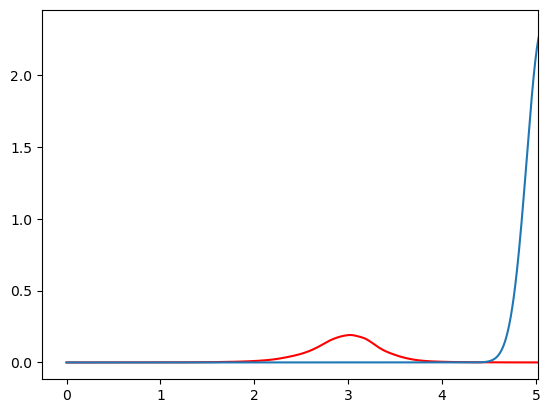

In [26]:
ascaso = Nc.ClusterMassAscaso()

ascaso.param_set_by_name("mup0", 4.45393539397061)
ascaso.param_set_by_name("mup1", 0.688627943224023)
ascaso.param_set_by_name("mup2", 1.23735536845047)
ascaso.param_set_by_name("sigmap0", 0.227197277810533)
ascaso.param_set_by_name("sigmap1", -0.0514034833229222)
ascaso.param_set_by_name("sigmap2", -0.125446104089159)
ascaso.param_set_by_name("cut", 1e15)


def p(model, lnM, z, lnR):
    
    lnR_mean =  model.get_mean_richness(lnM, z)
    lnR_std = model.get_std_richness(lnM, z) 
    
    pdf=[]
    for i in range(len(lnR)):
        x = (lnR[i] - lnR_mean) / lnR_std;
        pdf.append(1.0 / (np.sqrt(2 * np.pi) * lnR_std) * np.exp (-0.5 * x * x))

    return pdf



ascaso_pdf= p(ascaso, 34.0, 1.2, lnR_range) 

plt.plot(lnR_range, prob_lnR, c='r')
plt.plot(lnR_range, ascaso_pdf)

plt.xlim(None, max_lnR_cut)


In [23]:
def p(x):
    return [dist.eval(Ncm.Vector.new_array([34.0, 1.2, xi])) for xi in x]

def q(x):
    return stats.norm.pdf(x, loc=4.5, scale=2)

x =  np.linspace(min_lnR, max_lnR, 1000)
k = max(p(x) / q(x))

def rejection_sampling(ns):
    samples = []

    while len(samples) < ns:
        z = np.random.normal(4.5, 1)
        u = np.random.uniform(0, 1)

        if u <= dist.eval(Ncm.Vector.new_array([34.0, 1.2, z])) / (k * q(z)):
            samples.append(z)

    return np.array(samples)

s = rejection_sampling(10000)

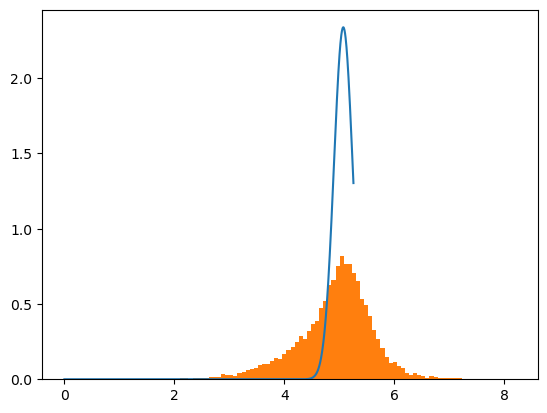

In [27]:
plt.plot(lnR_range, ascaso_pdf)
plt.hist(s, bins = 100, density=True)
plt.show()

In [17]:
m = np.mean(s)
sd = np.std(s)

In [18]:
lnM_a = np.log(dt_halos["m200c"])  # ln(mass)
z_a = dt_halos["redshift_true"]  # redshift
lnR_a = np.log(dt_halos["richness"])  # ln(richness)

In [19]:
# redshift intervals
z_0 = 0.0
z_1 = 0.05

lnR_binned_z =[]
halos_bin_z =[]
mean_bin_z =[]
for i in range(61):
    cut_z = np.logical_and (dt_halos['redshift_true'] > z_0, dt_halos['redshift_true'] < z_1)
    halos_bin_z.append(dt_halos[cut_z])
    lnR_binned_z.append(np.log(dt_halos[cut_z]["richness"]))
    mean_bin_z.append(np.mean(dt_halos[cut_z]["redshift_true"]))
    z_0 = z_0 + 0.05
    z_1 = z_1 + 0.05
 

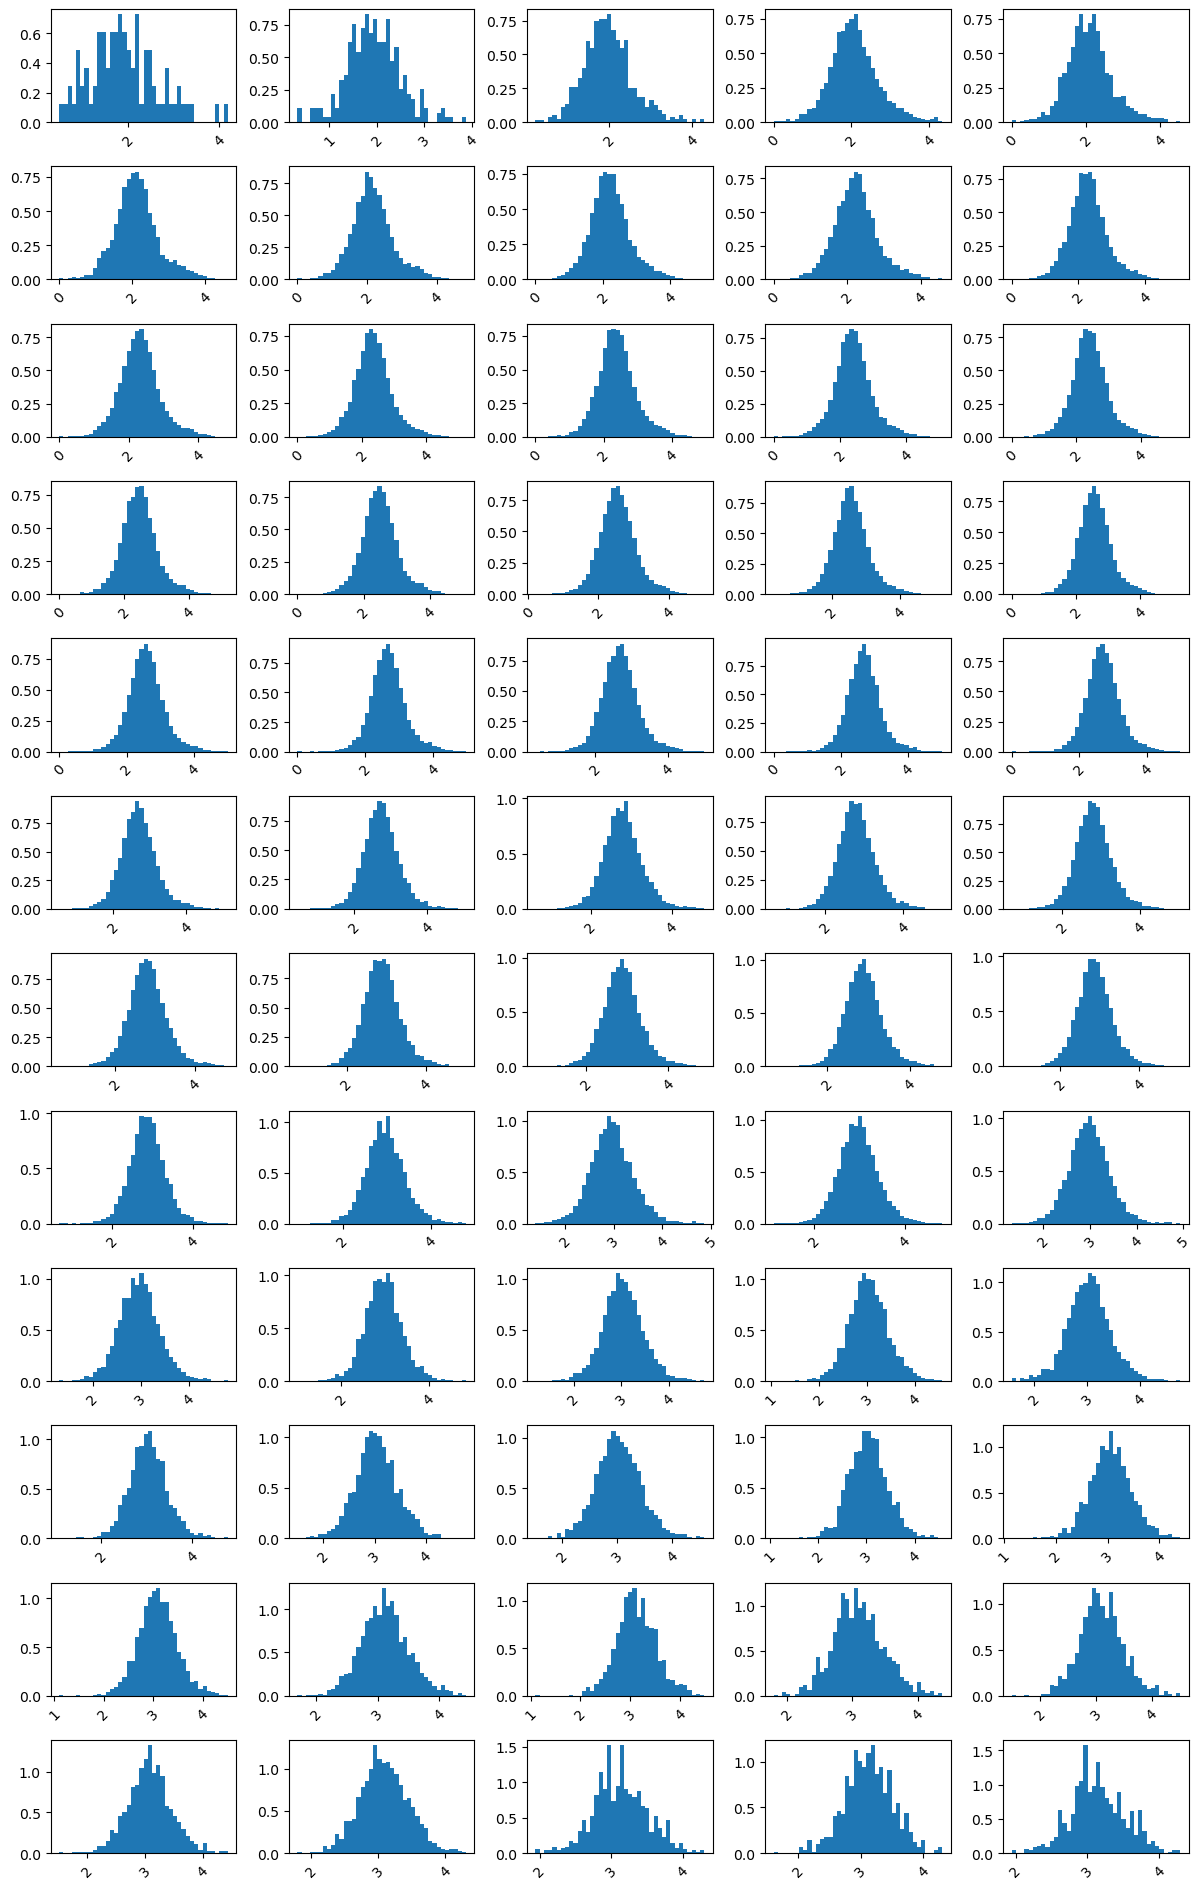

In [20]:
fig, axs = plt.subplots(nrows=12, ncols=5, figsize = (12,19))

for lnR_i, ax in zip(lnR_binned_z, axs.flat):
    ax.hist(lnR_i, bins=40, density=True)
    ax.tick_params(axis='x', labelrotation = 45)
fig.tight_layout()

plt.show()



In [21]:
# Mass intervals

lnM_0 = min(lnM_a)
lnM_1 = min(lnM_a) + 0.5

lnR_binned_m =[]
halos_bin_m =[]
for i in range(11):
    cut_lnM = np.logical_and (lnM_a > lnM_0, lnM_a < lnM_1)
    halos_bin_m.append(dt_halos[cut_lnM])
    lnR_binned_m.append(np.log(dt_halos[cut_lnM]["richness"]))

    lnM_0 = lnM_0 + 0.5
    lnM_1 = lnM_1 + 0.5
 

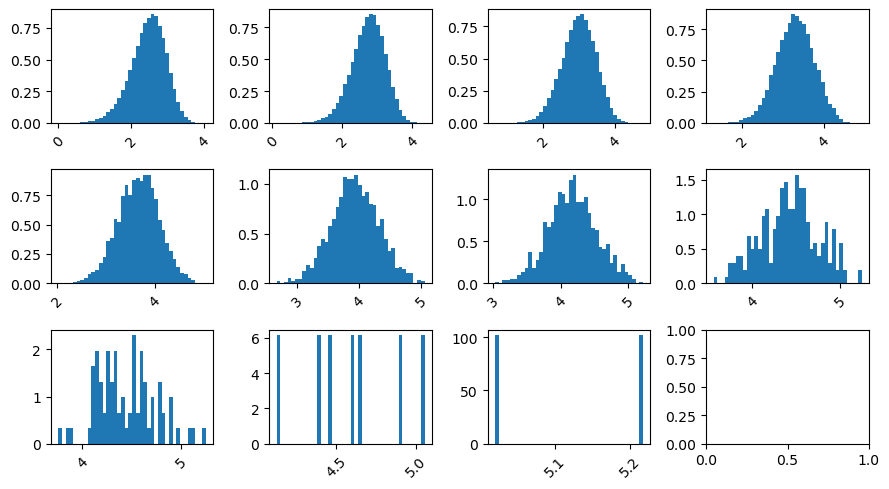

In [22]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize = (9,5))
for lnR_i, ax in zip(lnR_binned_m, axs.flat):
    ax.hist(lnR_i, bins=40, density=True)
    ax.tick_params(axis='x', labelrotation = 45)
fig.tight_layout()

plt.show()

In [21]:
# for j in range (len(lnR_binned_m)):
#     df =  pd.DataFrame(lnR_binned_m[j])
#     df.to_csv(f'Data_binned/lnR_binned_m{j}.csv')

In [22]:
# for j in range (len(lnR_binned_z)):
#     df =  pd.DataFrame(lnR_binned_z[j])
#     df.to_csv(f'Data_binned/lnR_binned_m{j}.csv')

In [23]:
 # len(lnR_binned_m[1])

In [24]:
# X = stats.truncnorm.rvs(-1, 1, 0.5, 1.0, size=1200000)
# a, b, loc, scale = stats.truncnorm.fit(np.array(X))
# print(a, b, loc, scale)

# x = np.linspace(-3, 3, 1000)
# pdf1 = stats.truncnorm.pdf(x, a, b, loc, scale)

# plt.plot(x, pdf1)


In [25]:
z_0 = 0.0
z_1 = 0.1
halos_bin_z =[]

for i in range(30):
    cut_z = np.logical_and (dt_halos['redshift_true'] > z_0, dt_halos['redshift_true'] < z_1)
    halos_bin_z.append(dt_halos[cut_z])
    z_0 = z_0 + 0.1
    z_1 = z_1 + 0.1

# mass bins
label = []
halos_bin_mz =[]
lnR_binned_mz=[]
for i in range(30):
    lnM_0 = min(lnM_a)
    lnM_1 = min(lnM_a) + 0.5

    for j in range(9):
        cut = np.logical_and (np.log(halos_bin_z[i]["m200c"]) > lnM_0, np.log(halos_bin_z[i]["m200c"]) < lnM_1)
        halos_bin_mz.append(halos_bin_z[i][cut])
        label.append(f"{min(halos_bin_z[i]['redshift_true'])} < z < {max(halos_bin_z[i]['redshift_true'])}\n{lnM_0} < lnM < {lnM_1}")
        lnR_binned_mz.append(np.log(halos_bin_z[i][cut]["richness"]))
        lnM_0 = lnM_0 + 0.5
        lnM_1 = lnM_1 + 0.5


/global/homes/c/cinlima/.conda/envs/numcosmo/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/global/homes/c/cinlima/.conda/envs/numcosmo/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/global/homes/c/cinlima/.conda/envs/numcosmo/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/homes/c/cinlima/.conda/envs/numcosmo/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/global/homes/c/cinlima/.conda/envs/numcosmo/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.typ

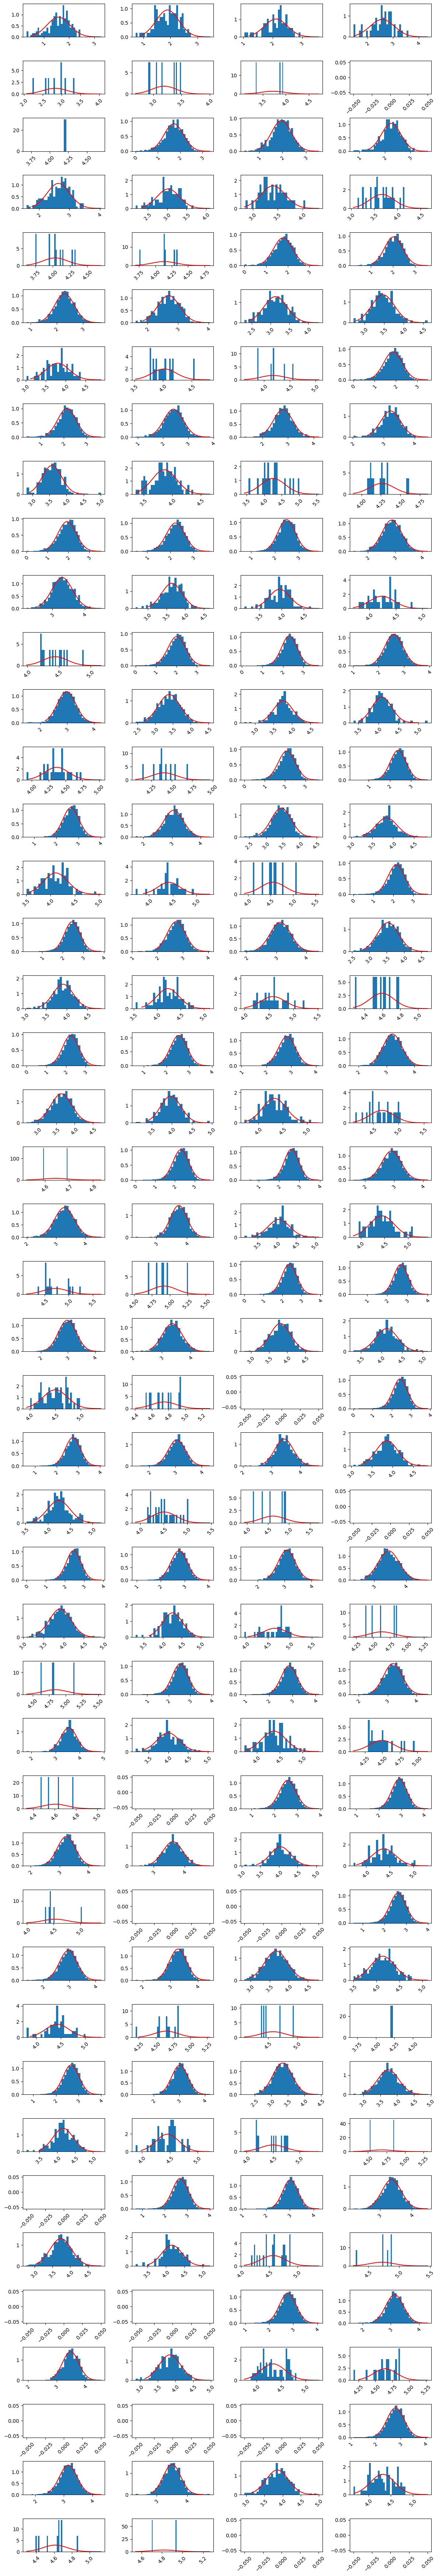

In [26]:
fig, axs = plt.subplots(nrows=45, ncols=4, figsize = (12,70))
for lnR_i, ax in zip(lnR_binned_mz, axs.flat):
    
    points = np.linspace(stats.norm.ppf(0.01,loc=np.mean(lnR_i),scale=np.std(lnR_i)),
                 stats.norm.ppf(0.9999,loc=np.mean(lnR_i),scale=np.std(lnR_i)),100)
    
    ax.hist(lnR_i, bins=30, density=True)
    ax.plot(points, stats.norm.pdf(points, np.mean(lnR_i), np.std(lnR_i)), color='r')

    ax.tick_params(axis='x', labelrotation = 45)

fig.tight_layout()




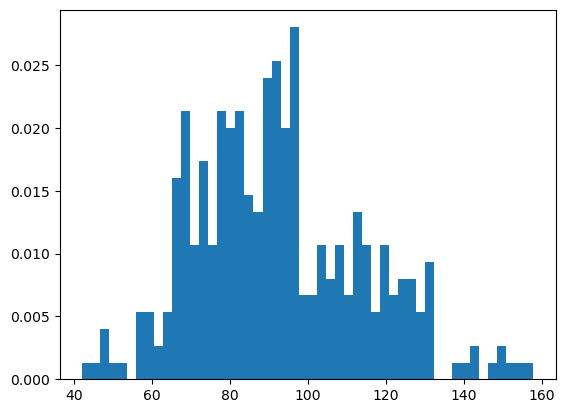

In [27]:
dt_halos_high_cut = dt_halos[np.logical_and(dt_halos["m200c"] > 134364186006715.5, dt_halos['redshift_true'] > 1.299973726272583) ]
plt.hist(dt_halos_high_cut['richness'], bins=50, density=True)
plt.show()

In [28]:
for lnR_i in lnR_binned_z:
    if len(lnR_i) == 0:
        pass
    
    else:
        print(stats.kstest(lnR_i, stats.norm.cdf, args=(np.mean(lnR_i), np.std(lnR_i))))

KstestResult(statistic=0.05995723655327578, pvalue=0.8870679601509671, statistic_location=1.8808289500667217, statistic_sign=1)
KstestResult(statistic=0.046292684711092394, pvalue=0.5030321896307168, statistic_location=1.3752434505701414, statistic_sign=-1)
KstestResult(statistic=0.04664169341824498, pvalue=0.060687837970528125, statistic_location=2.2081388185731754, statistic_sign=1)
KstestResult(statistic=0.04802360957570906, pvalue=0.00035784008559614573, statistic_location=2.2872467362877837, statistic_sign=1)
KstestResult(statistic=0.05265986411143131, pvalue=1.560535277496644e-07, statistic_location=2.4146162710548165, statistic_sign=1)
KstestResult(statistic=0.05705108538940262, pvalue=2.1133900418230093e-11, statistic_location=2.4811581905012847, statistic_sign=1)
KstestResult(statistic=0.04840064027295887, pvalue=5.1438715227497197e-11, statistic_location=2.379643787895729, statistic_sign=1)
KstestResult(statistic=0.04337430236080886, pvalue=6.62659627915807e-11, statistic_loc